# Load Dataset

In [1]:
#import library
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from collections import defaultdict
import re
from collections import defaultdict, Counter

C:\Users\User\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#load dataset
df = pd.read_csv("ukraine_before_conflict.csv",encoding='utf-8')
df = df[['article_title', 'author', 'published_time', 'article_text']]
df.head()

,article_title,author,published_time,article_text
0,Title not found,Author not found,Published time not found,Article text not found
1,Ukrainian president expects no conflict with R...,By Xinhua,"Published: Feb 23, 2022 09:34 AM",Ukrainian President Volodymyr Zelensky attends...
2,British PM announces sanctions against Russia ...,By Xinhua,"Published: Feb 23, 2022 09:37 AM",British Prime Minister Boris Johnson Photo: VC...
3,NATO chief urges Russia to choose diplomacy in...,By Xinhua,"Published: Feb 23, 2022 09:41 AM",NATO Secretary General Jens Stoltenberg speaks...
4,"EU agrees Russia sanctions package, warns of f...",By Xinhua,"Published: Feb 23, 2022 09:42 AM",European Commission President Ursula von der L...


In [3]:
df.shape

(204, 4)

In [4]:
#check and remove incomplete data
check_condition = (df['article_text'] == 'Article text not found') & (df['author'] == 'Author not found')
df = df[~check_condition]

In [5]:
df.shape

(188, 4)

# Disambiguation Handling using Rule Based Method

In [6]:
dict_df = pd.read_excel('dict_ukraine.xlsx')
dict_df.head()

,variation,standard
0,Ukraine,Ukraine
1,Ukrainian,Ukraine
2,Russia,Russia
3,Russian,Russia
4,Russians,Russia


In [7]:
word_dict = pd.Series(dict_df.standard.values, index=dict_df.variation).to_dict()
word_dict

{'Ukraine': 'Ukraine',
 'Ukrainian': 'Ukraine',
 'Russia': 'Russia',
 'Russian': 'Russia',
 'Russians': 'Russia',
 'Russia Federation': 'Russia',
 'China': 'China',
 'Chinese': 'China',
 'Israel': 'Israel',
 'Israeli': 'Israel',
 'Palestine': 'Palestine',
 'Palestinian': 'Palestine',
 'US': 'US',
 "US'": 'US',
 'United States': 'US',
 'America': 'US',
 'American': 'US',
 'Americans': 'US',
 'Europe': 'EU',
 'European': 'EU',
 'European Union': 'EU',
 'EU': 'EU',
 'Eastern Europe': 'EU',
 'Eastern European': 'EU',
 'Western Europe': 'EU',
 'Winter Olympic Games': 'Winter Olympic Games',
 '2022 Olympic Winter Games': 'Winter Olympic Games',
 '2022 Winter Olympic Games': 'Winter Olympic Games',
 '2022 Winter Olympics': 'Winter Olympic Games',
 'Olympic Games': 'Winter Olympic Games',
 'Winter Games': 'Winter Olympic Games',
 'Winter Olympics': 'Winter Olympic Games',
 'Olympic Winter Games Beijing 2022': 'Winter Olympic Games',
 'Beijing 2022 Olympic Winter Games': 'Winter Olympic Games',

In [9]:
def standardize_text(text, word_dict):
    lower_word_dict = {key.lower(): value for key, value in word_dict.items()}
    sorted_keys = sorted(lower_word_dict.keys(), key=len, reverse=True)
    
    #pattern to matches any of the keys
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(key) for key in sorted_keys) + r')\b', re.IGNORECASE)
    
    def replace(match):
        word = match.group(0)
        lower_word = word.lower()
        return lower_word_dict.get(lower_word, word)
    
    #replace words in the text using the pattern and the replace function
    standardized_text = pattern.sub(replace, text)
    return standardized_text

In [10]:
text = """The conflict in Ukrainian and Russian people is escalated. Vladimir Putin and Joe Biden is fighting. 
        United States. european union, eu council, and 2022 olympic winter games, un security council, 2022 winter olympic games, un human rights council, 
        2022 winter olympics, security council, olympic games, western, winter games, northwest china, winter olympics, east china,
        olympic winter games beijing 2022, western ukraine, beijing 2022 olympic winter games, GT, beijing olympic games, CPC Central Committee,
        beijing winter olympics, un general assembly, Communist Party of China Central Committee, olympic winter games. EU Council. NATO COuncil.
        Beijing Winter Olympic Games. Paralympic Winter Olympic Games. Winter Olympic Games Beijing 2022. Donetsk People's Republic.
        Joe B.
        IC Emmanuel Dennis"""

In [11]:
text = """.I am not a fan of conspiracy theories, but one couldn't help but notice that US diplomats' concerns have been very opportune. As early as late January, a few days before the Beijing Winter Olympic Games, little birds in Foggy Bottom told media that they planned to implement authorization departure on their diplomats and consular officers in China until they feel safe to return."""

In [12]:
standardized_text = standardize_text(text, word_dict)
print(standardized_text)

.I am not a fan of conspiracy theories, but one couldn't help but notice that US diplomats' concerns have been very opportune. As early as late January, a few days before Winter Olympic Games, little birds in Foggy Bottom told media that they planned to implement authorization departure on their diplomats and consular officers in China until they feel safe to return.


In [13]:
df['article_text'] = df['article_text'].apply(lambda x: standardize_text(x, word_dict))
df.head()

,article_title,author,published_time,article_text
1,Ukrainian president expects no conflict with R...,By Xinhua,"Published: Feb 23, 2022 09:34 AM",Ukraine President Volodymyr Zelensky attends a...
2,British PM announces sanctions against Russia ...,By Xinhua,"Published: Feb 23, 2022 09:37 AM",UK Prime Minister Boris Johnson Photo: VCG UK ...
3,NATO chief urges Russia to choose diplomacy in...,By Xinhua,"Published: Feb 23, 2022 09:41 AM",NATO Secretary General Jens Stoltenberg speaks...
4,"EU agrees Russia sanctions package, warns of f...",By Xinhua,"Published: Feb 23, 2022 09:42 AM",EU Commission President Ursula von der Leyen m...
5,Russia's upper house approves use of military ...,By Xinhua,"Published: Feb 23, 2022 09:48 AM",Russia President Vladimir Putin signs document...


In [59]:
df.to_csv('Ukraine_before_conflict_preprocessed.csv', index=False)

# NER using BERT

In [14]:
#load pretrained model and tokenizer
model_name = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

In [15]:
#create NER pipeline
nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

In [16]:
#function to merge subwords
def merge_subwords(ner_results):
    merged_results = []
    for res in ner_results:
        if res['word'].startswith('##'):
            merged_results[-1]['word'] += res['word'][2:]
            merged_results[-1]['end'] = res['end']
        else:
            merged_results.append(res)
    return merged_results

In [17]:
#function to resolve inconsistent labels
def resolve_entity_labels(ner_results):
    entity_dict = defaultdict(lambda: defaultdict(int))
    
    for entity in ner_results:
        entity_text = entity['word']
        entity_label = entity['entity_group']
        entity_dict[entity_text][entity_label] += 1
    
    resolved_entities = {}
    for entity_text, labels in entity_dict.items():
        resolved_label = max(labels, key=labels.get)
        resolved_entities[entity_text] = (resolved_label, sum(labels.values()))
    return resolved_entities

#function to extract named entities
def extract_named_entities(text):
    ner_results = nlp(text)
    merged_results = merge_subwords(ner_results)
    #resolve inconsistent labels
    resolved_entities = resolve_entity_labels(merged_results)
    return resolved_entities

#function to consolidate entities
def consolidate_entities(entities):
    consolidated = defaultdict(lambda: defaultdict(int))
    partial_names = set()

    for entity, (entity_group, count) in entities.items():
        parts = entity.split()
        if len(parts) > 1:
            consolidated[entity_group][entity] += count
            #aggregate counts from shorter forms
            for part in parts:
                if part in entities and entities[part][0] == entity_group:
                    consolidated[entity_group][entity] += entities[part][1]
                    partial_names.add(part)
        else:
            if entity not in partial_names:
                consolidated[entity_group][entity] += count

    for part in partial_names:
        if part in consolidated[entity_group]:
            del consolidated[entity_group][part]

    flat_consolidated = {}
    for entity_group, entity_dict in consolidated.items():
        for name, count in entity_dict.items():
            flat_consolidated[name] = (entity_group, count)

    return flat_consolidated

#apply the functions to the dataset
ner_results_list = []
for text in df['article_text']:
    entities = extract_named_entities(text)
    consolidated_entities = consolidate_entities(entities)
    ner_results_list.append(consolidated_entities)

df['NER'] = ner_results_list
df.to_csv('BERT_NER_UKRAINEBEFORECONFLICT.csv', index=False, encoding='utf-8')

# Exploratory Data Analysis

In [19]:
#EDA
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [20]:
#words distribution named entities and non-entities
def count_words_distribution(text):
    named_entity_words = sum([count for entity_type, count in text.values()])
    return named_entity_words

df['Named_Entity_Words'] = df['NER'].apply(count_words_distribution)
df['total_words'] = df['article_text'].apply(len)
df['Non_Entity_Words'] = df['total_words'] - df['Named_Entity_Words']
df.head()

,article_title,author,published_time,article_text,NER,Named_Entity_Words,total_words,Non_Entity_Words
1,Ukrainian president expects no conflict with R...,By Xinhua,"Published: Feb 23, 2022 09:34 AM",Ukraine President Volodymyr Zelensky attends a...,"{'Ukraine': ('LOC', 6), 'Kiev': ('LOC', 2), 'R...",32,1214,1182
2,British PM announces sanctions against Russia ...,By Xinhua,"Published: Feb 23, 2022 09:37 AM",UK Prime Minister Boris Johnson Photo: VCG UK ...,"{'UK': ('LOC', 5), 'Russia': ('LOC', 6), 'Ukra...",29,1264,1235
3,NATO chief urges Russia to choose diplomacy in...,By Xinhua,"Published: Feb 23, 2022 09:41 AM",NATO Secretary General Jens Stoltenberg speaks...,"{'NATO - Ukraine Commission': ('ORG', 14), 'Xi...",44,1832,1788
4,"EU agrees Russia sanctions package, warns of f...",By Xinhua,"Published: Feb 23, 2022 09:42 AM",EU Commission President Ursula von der Leyen m...,"{'EU Commission': ('ORG', 12), 'Xinhua': ('ORG...",57,3508,3451
5,Russia's upper house approves use of military ...,By Xinhua,"Published: Feb 23, 2022 09:48 AM",Russia President Vladimir Putin signs document...,"{'Russia': ('LOC', 6), 'Donetsk': ('LOC', 3), ...",35,1343,1308


In [21]:
total_words = df['total_words'].sum()
total_named_entity_words = df['Named_Entity_Words'].sum()
total_non_entity_words = total_words - total_named_entity_words
average_words_per_article = total_words / len(df)
percentage_named_entity_words = (total_named_entity_words / total_words) * 100

print("Total Words: ", total_words)
print("Total Named Entity Words: ", total_named_entity_words)
print("Total Non-Named Entity Words: ", total_non_entity_words)
print("Average number of words per article/length:", average_words_per_article)
print("Percentage of words in articles that are named entities:", percentage_named_entity_words)

Total Words:  917515
Total Named Entity Words:  8547
Total Non-Named Entity Words:  908968
Average number of words per article/length: 4880.398936170212
Percentage of words in articles that are named entities: 0.9315379040124685


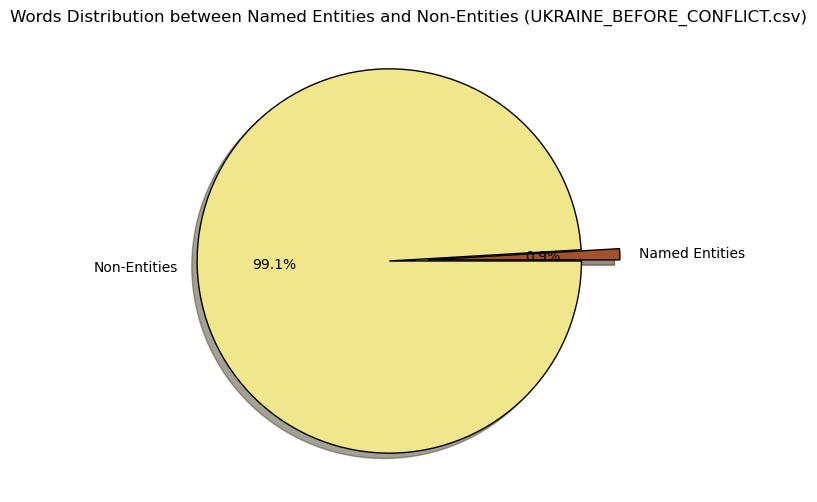

In [22]:
labels = ['Named Entities', 'Non-Entities']
sizes = [total_named_entity_words, total_non_entity_words]
colors = ['sienna','khaki']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', explode=(0.2, 0), shadow=True, wedgeprops={'edgecolor': 'black'})
plt.title('Words Distribution between Named Entities and Non-Entities (UKRAINE_BEFORE_CONFLICT.csv)')
plt.axis('equal')
plt.show()

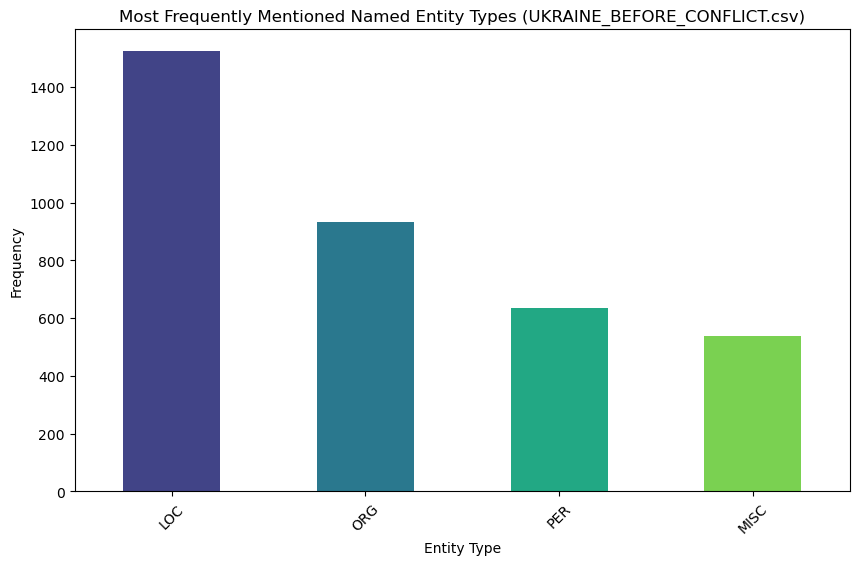

In [23]:
#most frequently mentioned named entity type
def count_entity_types(text):
    entity_types = [entity_type for entity_type, _ in text.values()]
    return entity_types

entity_types = df['NER'].apply(count_entity_types).explode().value_counts()
colors = sns.color_palette('viridis', len(entity_types))

plt.figure(figsize=(10, 6))
entity_types.plot(kind='bar', color=colors)
plt.title('Most Frequently Mentioned Named Entity Types (UKRAINE_BEFORE_CONFLICT.csv)')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

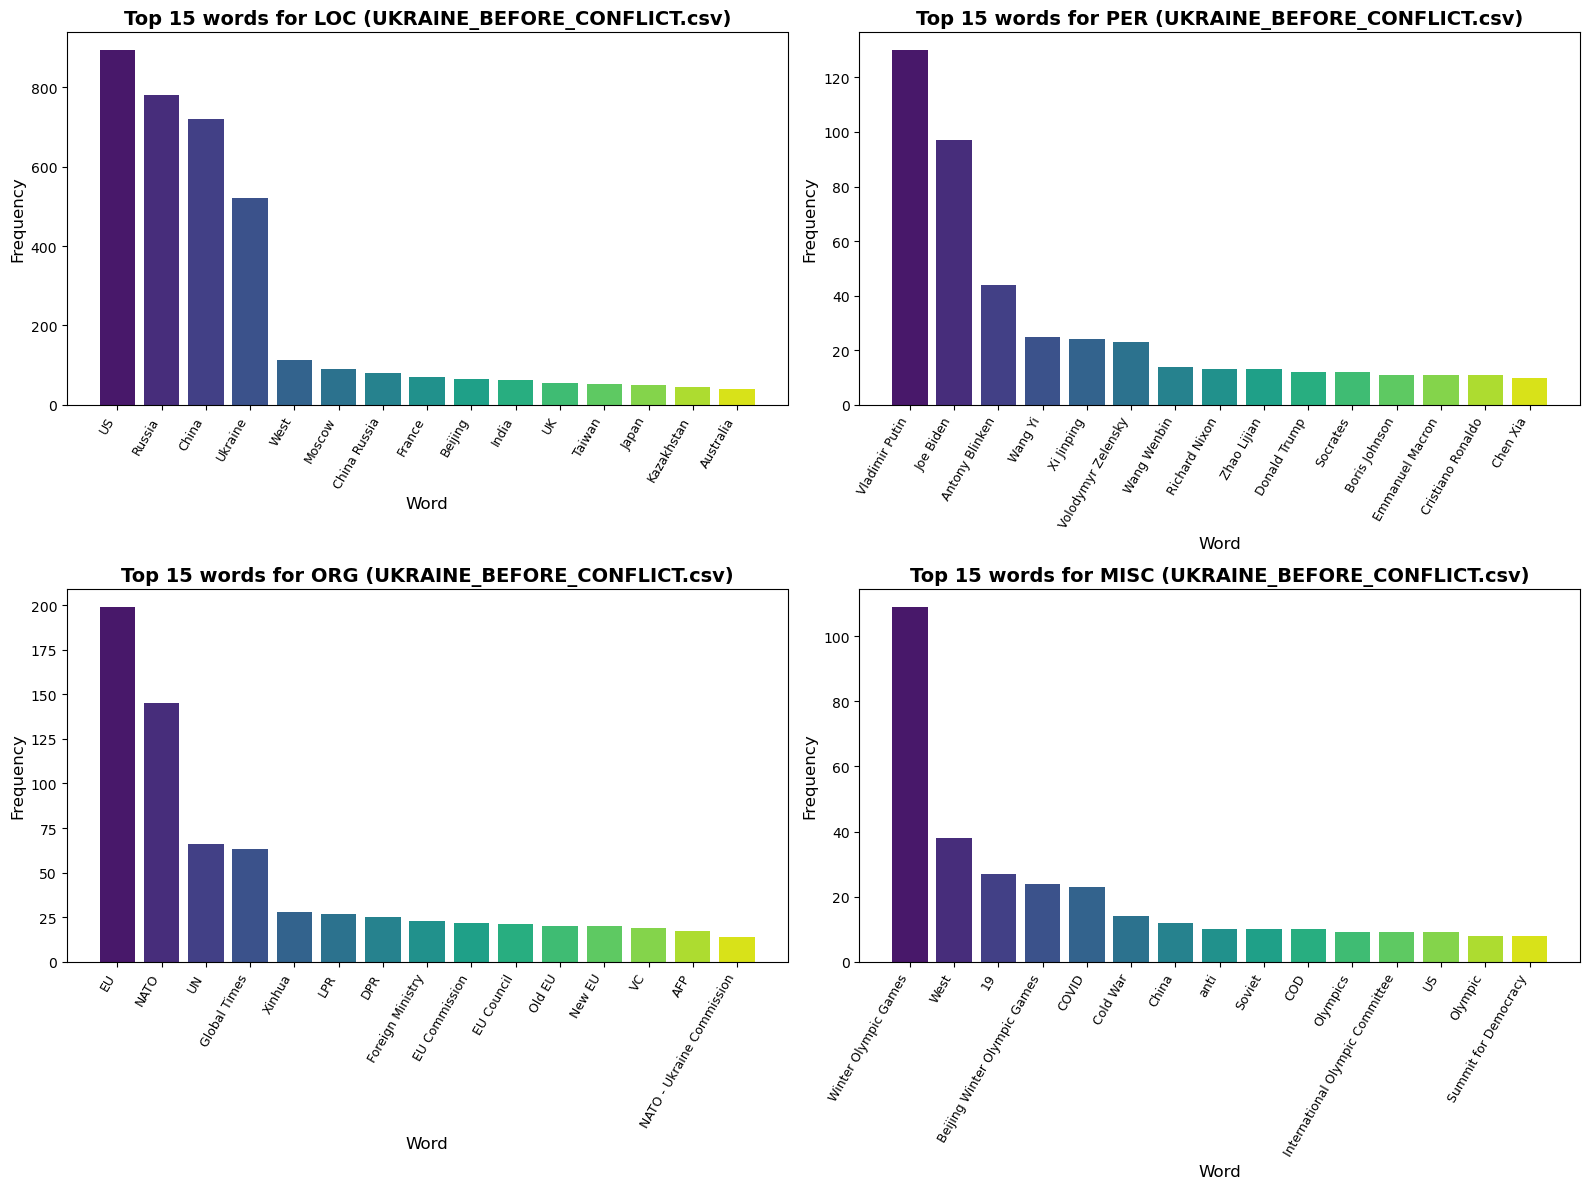

In [28]:
#top 15 words for each entity type
entity_words_dict = defaultdict(Counter)

for ner_dict in df['NER']:
    for word, (entity_type, count) in ner_dict.items():
        entity_words_dict[entity_type][word] += count

colors = sns.color_palette('viridis', 15)
plt.figure(figsize=(16, 12))

for i, (entity_type, words_counter) in enumerate(entity_words_dict.items(), 1):
    top_words = dict(words_counter.most_common(15))
    plt.subplot(2, 2, i)
    plt.bar(top_words.keys(), top_words.values(), color=colors)
    plt.title('Top 15 words for ' + entity_type + ' (UKRAINE_BEFORE_CONFLICT.csv)', fontsize=14, fontweight='bold')
    plt.xlabel('Word', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=60, fontsize=9, ha="right")

plt.tight_layout()
plt.show()

In [31]:
#save top 50 words for each entity type in excel file
entity_words_dict = defaultdict(Counter)

for ner_dict in df['NER']:
    for word, (entity_type, count) in ner_dict.items():
        entity_words_dict[entity_type][word] += count

data = {'Entity Type': [], 'Word': [], 'Count': []}

for entity_type, words_counter in entity_words_dict.items():
    top_words = words_counter.most_common(40)
    for word, count in top_words:
        data['Entity Type'].append(entity_type)
        data['Word'].append(word)
        data['Count'].append(count)

df_top_words = pd.DataFrame(data)
excel_file_path = 'Ukraine_before_conflict_TopWords_v2.xlsx'
df_top_words.to_excel(excel_file_path, index=False)

print(f"Top words by entity type have been saved to {excel_file_path}.")

Top words by entity type have been saved to Ukraine_before_conflict_TopWords_v2.xlsx.
